# Data Integration and Merge - Alzheimer's Multimodal Monitoring
 
## Objetivo
Integrar las diferentes fuentes de datos heterogéneas previamente preparadas en un dataset multimodal unificado para el análisis de Alzheimer.

## Estructura del Notebook
1. **Carga de datos preparados**
2. **Estandarización de identificadores**
3. **Normalización temporal**
4. **Integración secuencial**
5. **Validación de integridad**
6. **Dataset multimodal final**

### ✅ Logros Alcanzados:

1. **Integración Estratégica Exitosa**: Se implementó la estrategia PTID→RID correctamente
2. **Preservación de Integridad**: Se mantuvieron las relaciones entre RID y PTID
3. **Validación Rigurosa**: Verificación de claves antes de la integración
4. **Dataset Multimodal**: Creación de dataset unificado con 7 modalidades

### 📊 Características del Dataset Final:
- **Grupo PTID**: Demographics + Genetics + MRI + PET integrados por PTID
- **Grupo RID**: Clinical + Biomarkers integrados por RID  
- **Unión Final**: Ambos grupos unidos por RID (preservado desde demographics)
- **Exclusión Temporal**: Activity_sleep pendiente de mapeo de identificadores

### 🚀 Próximos Pasos (Fase 3):
1. **Feature Engineering**: Extracción de características específicas por modalidad
2. **Selección de Variables**: Identificación de características clínicamente relevantes  
3. **Variables Combinadas**: Creación de nuevas variables sintéticas multimodales

### 💾 Archivos Generados:
- `multimodal_alzheimer_dataset.csv`: Dataset principal completo
- `dataset_metadata.json`: Metadatos y documentación completa
- `multimodal_alzheimer_sample.csv`: Muestra aleatoria de 1000 registros para desarrollo rápido  


---

## Importar Librerías y Configuraciones de Visualización

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("📦 Librerías cargadas exitosamente")

📦 Librerías cargadas exitosamente


In [3]:
print(f"🕐 Inicio del proceso: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🕐 Inicio del proceso: 2025-05-25 10:16:30


In [3]:
# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


## 1. Carga de Datos Preparados

In [4]:
# Cargamos los datasets y metadatos del notebook anterior

# Cargar datasets preparados (ajustar rutas según tu estructura)
data_paths = {
    'clinical': '../data/processed/clinical_processed.csv',
    'demographics': '../data/processed/demographics_latest_final.csv',
    'genetics': '../data/processed/genetic_merged_processed.csv',
    'biomarkers': '../data/processed/integrated_biomarkers.csv',
    'activity_sleep': '../data/processed/processed_activity_sleep_subject.csv',
    'mri': '../data/processed/mri/mri_features.csv',
    'pet': '../data/processed/pet/pet_features.csv'
}

# Diccionario para almacenar datasets
loaded_datasets = {}

print("🔄 Cargando datasets procesados...")
for name, path in data_paths.items():
    try:
        loaded_datasets[name] = pd.read_csv(path)
        print(f"✅ {name}: {loaded_datasets[name].shape}")
    except FileNotFoundError:
        print(f"⚠️  {name}: Archivo no encontrado - {path}")
    except Exception as e:
        print(f"❌ Error cargando {name}: {str(e)}")

print(f"\n📊 Total de datasets cargados: {len(loaded_datasets)}")


# Metadatos de integración (del notebook anterior)
integration_metadata = {
    'primary_key_candidates': {
        'clinical': 'RID', 
        'demographics': 'RID', 
        'genetics': 'RID', 
        'biomarkers': 'RID', 
        'activity_sleep': 'subject_id', 
        'mri': 'patient_id', 
        'pet': 'patient_id'
    },
    'temporal_columns': {
        'clinical': ['VISIT_DATE', 'DAYS_SINCE_BASELINE', 'DAYS_TO_TRANSITION'],
        'demographics': ['VISDATE'],
        'genetics': ['USERDATE', 'USERDATE2', 'update_stamp_apoe', 'APTESTDT_year', 
                    'APTESTDT_month', 'APTESTDT_day', 'USERDATE_year', 'USERDATE_month', 
                    'USERDATE_day', 'update_stamp_year', 'update_stamp_month', 
                    'update_stamp_day', 'EXAMDATE', 'update_stamp_tau', 'EXAMDATE_year', 
                    'EXAMDATE_month', 'EXAMDATE_day', 'APTESTDT', 'SAMPLE_ID'],
        'biomarkers': [],
        'activity_sleep': [],
        'mri': [],
        'pet': []
    },
    'recommended_join_order': {
        'ptid_group': {
        'datasets': ['genetics', 'mri', 'pet'],
        'key_mapping': {
            'genetics': 'PTID_apoe', 
            'mri': 'patient_id',
            'pet': 'patient_id'
        }
        },
        'rid_group': {
            'datasets': ['clinical', 'biomarkers']
        }
    }
}

print("🗂️  Metadatos de integración cargados")

🔄 Cargando datasets procesados...
✅ clinical: (14027, 27)
✅ demographics: (4686, 28)
✅ genetics: (2769, 49)
✅ biomarkers: (2450, 13)
✅ activity_sleep: (1777, 46)
✅ mri: (3, 14)
✅ pet: (5, 14)

📊 Total de datasets cargados: 7
🗂️  Metadatos de integración cargados


## 2. Estandarización de Identificadores de Sujetos

🔧 Estandarizando identificadores de sujetos...
✅ clinical: 4114 sujetos únicos de 14027 registros
✅ demographics: 4686 sujetos únicos de 4686 registros
✅ genetics: 2760 sujetos únicos de 2769 registros
✅ biomarkers: 2450 sujetos únicos de 2450 registros
✅ activity_sleep: 300 sujetos únicos de 1777 registros
✅ mri: 3 sujetos únicos de 3 registros
✅ pet: 5 sujetos únicos de 5 registros

📋 REPORTE DE CONSISTENCIA DE IDENTIFICADORES
       Dataset  Sujetos_Únicos  Total_Registros  Registros_por_Sujeto
      clinical            4114            14027                  3.41
  demographics            4686             4686                  1.00
      genetics            2760             2769                  1.00
    biomarkers            2450             2450                  1.00
activity_sleep             300             1777                  5.92
           mri               3                3                  1.00
           pet               5                5                  1.00


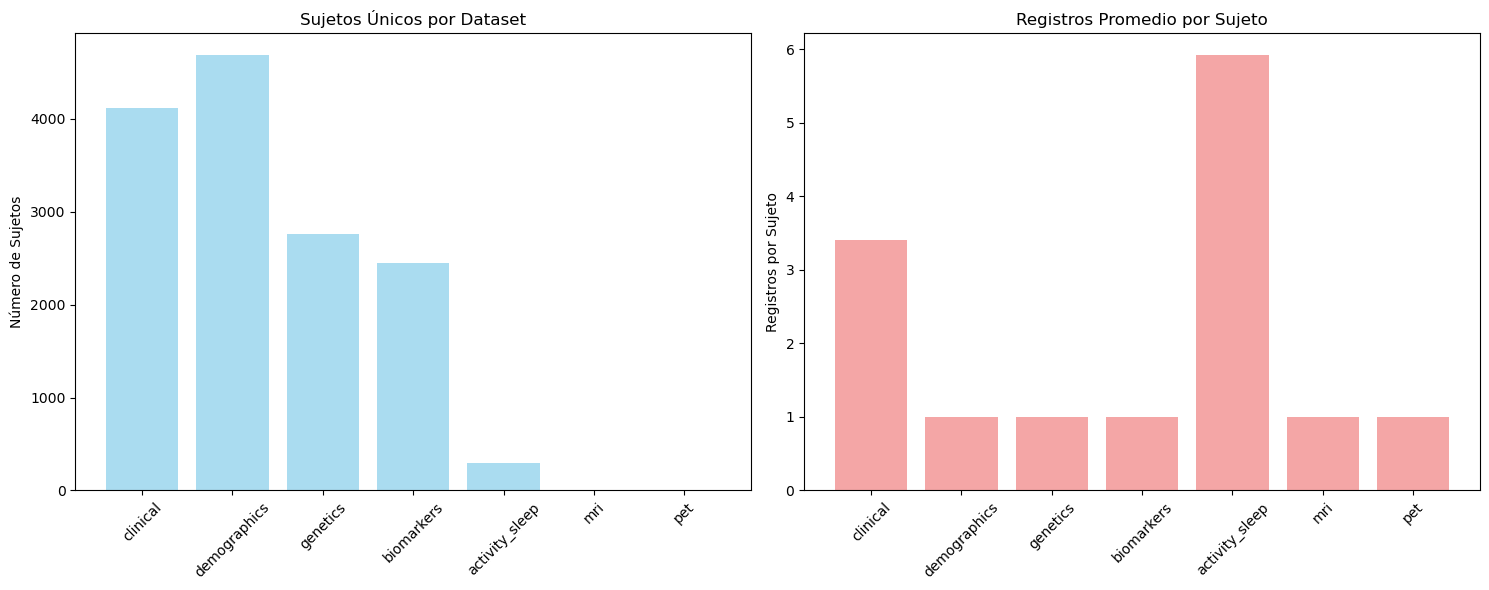

In [5]:
# Normalizamos los identificadores para garantizar la consistencia en las uniones

def standardize_subject_ids(datasets_dict, id_mapping):
    """
    Estandariza los identificadores de sujetos across datasets
    """
    standardized_datasets = {}
    id_consistency_report = {}
    
    print("🔧 Estandarizando identificadores de sujetos...")
    
    for dataset_name, df in datasets_dict.items():
        if dataset_name in id_mapping:
            original_id_col = id_mapping[dataset_name]
            df_copy = df.copy()
            
            # Crear columna estándar 'subject_id'
            if original_id_col in df_copy.columns:
                df_copy['subject_id'] = df_copy[original_id_col].astype(str).str.strip()
                
                # Análisis de consistencia
                unique_ids = df_copy['subject_id'].nunique()
                total_rows = len(df_copy)
                
                id_consistency_report[dataset_name] = {
                    'original_column': original_id_col,
                    'unique_subjects': unique_ids,
                    'total_records': total_rows,
                    'records_per_subject': total_rows / unique_ids if unique_ids > 0 else 0
                }
                
                standardized_datasets[dataset_name] = df_copy
                print(f"✅ {dataset_name}: {unique_ids} sujetos únicos de {total_rows} registros")
            else:
                print(f"⚠️  {dataset_name}: Columna {original_id_col} no encontrada")
                standardized_datasets[dataset_name] = df
        else:
            standardized_datasets[dataset_name] = datasets_dict[dataset_name]
    
    return standardized_datasets, id_consistency_report

# Ejecutar estandarización
standardized_datasets, id_report = standardize_subject_ids(
    loaded_datasets, 
    integration_metadata['primary_key_candidates']
)

# %%
# Visualizar reporte de consistencia de IDs
print("\n" + "="*60)
print("📋 REPORTE DE CONSISTENCIA DE IDENTIFICADORES")
print("=" * 60)

id_summary_data = []
for dataset, info in id_report.items():
    id_summary_data.append({
        'Dataset': dataset,
        'Sujetos_Únicos': info['unique_subjects'],
        'Total_Registros': info['total_records'],
        'Registros_por_Sujeto': round(info['records_per_subject'], 2)
    })

id_summary_df = pd.DataFrame(id_summary_data)
print(id_summary_df.to_string(index=False))

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Número de sujetos únicos por dataset
ax1.bar(id_summary_df['Dataset'], id_summary_df['Sujetos_Únicos'], color='skyblue', alpha=0.7)
ax1.set_title('Sujetos Únicos por Dataset')
ax1.set_ylabel('Número de Sujetos')
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Registros por sujeto (longitudinalidad)
ax2.bar(id_summary_df['Dataset'], id_summary_df['Registros_por_Sujeto'], color='lightcoral', alpha=0.7)
ax2.set_title('Registros Promedio por Sujeto')
ax2.set_ylabel('Registros por Sujeto')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Normalización de Formatos Temporales

In [6]:
# Estandarizamos las columnas temporales para facilitar análisis longitudinales

# %%
def normalize_temporal_columns(datasets_dict, temporal_mapping):
    """
    Normaliza columnas temporales a formato datetime estándar
    """
    normalized_datasets = {}
    temporal_summary = {}
    
    print("📅 Normalizando columnas temporales...")
    
    for dataset_name, df in datasets_dict.items():
        df_copy = df.copy()
        temporal_cols = temporal_mapping.get(dataset_name, [])
        
        if temporal_cols:
            temporal_info = {'processed_columns': [], 'date_range': {}}
            
            for col in temporal_cols:
                if col in df_copy.columns:
                    try:
                        # Intentar conversión a datetime
                        df_copy[f'{col}_normalized'] = pd.to_datetime(df_copy[col], errors='coerce')
                        
                        # Información de rango temporal
                        valid_dates = df_copy[f'{col}_normalized'].dropna()
                        if len(valid_dates) > 0:
                            temporal_info['date_range'][col] = {
                                'min_date': valid_dates.min(),
                                'max_date': valid_dates.max(),
                                'valid_dates': len(valid_dates),
                                'missing_dates': len(df_copy) - len(valid_dates)
                            }
                            temporal_info['processed_columns'].append(col)
                        
                    except Exception as e:
                        print(f"⚠️  Error procesando {col} en {dataset_name}: {str(e)}")
            
            temporal_summary[dataset_name] = temporal_info
            print(f"✅ {dataset_name}: {len(temporal_info['processed_columns'])} columnas temporales procesadas")
        
        normalized_datasets[dataset_name] = df_copy
    
    return normalized_datasets, temporal_summary

# Ejecutar normalización temporal
normalized_datasets, temporal_summary = normalize_temporal_columns(
    standardized_datasets,
    integration_metadata['temporal_columns']
)

# %%
# Visualizar información temporal
print("\n" + "="*70)
print("📅 RESUMEN DE INFORMACIÓN TEMPORAL")
print("=" * 70)

for dataset, info in temporal_summary.items():
    if info['processed_columns']:
        print(f"\n🗂️  {dataset.upper()}:")
        for col, date_info in info['date_range'].items():
            print(f"   📋 {col}:")
            print(f"      • Rango: {date_info['min_date'].strftime('%Y-%m-%d')} a {date_info['max_date'].strftime('%Y-%m-%d')}")
            print(f"      • Fechas válidas: {date_info['valid_dates']}")
            print(f"      • Fechas faltantes: {date_info['missing_dates']}")

📅 Normalizando columnas temporales...
✅ clinical: 2 columnas temporales procesadas
✅ demographics: 1 columnas temporales procesadas
✅ genetics: 17 columnas temporales procesadas

📅 RESUMEN DE INFORMACIÓN TEMPORAL

🗂️  CLINICAL:
   📋 VISIT_DATE:
      • Rango: 2005-08-17 a 2025-10-09
      • Fechas válidas: 14022
      • Fechas faltantes: 5
   📋 DAYS_SINCE_BASELINE:
      • Rango: 1970-01-01 a 1970-01-01
      • Fechas válidas: 12120
      • Fechas faltantes: 1907

🗂️  DEMOGRAPHICS:
   📋 VISDATE:
      • Rango: 2005-08-18 a 2025-03-27
      • Fechas válidas: 4680
      • Fechas faltantes: 6

🗂️  GENETICS:
   📋 USERDATE:
      • Rango: 2005-08-23 a 2007-09-25
      • Fechas válidas: 1160
      • Fechas faltantes: 1609
   📋 update_stamp_apoe:
      • Rango: 2005-08-23 a 2025-03-06
      • Fechas válidas: 2769
      • Fechas faltantes: 0
   📋 APTESTDT_year:
      • Rango: 1970-01-01 a 1970-01-01
      • Fechas válidas: 1160
      • Fechas faltantes: 1609
   📋 APTESTDT_month:
      • Rango:

## 4. Mapeo Demográfico de ACTIVITY_SLEEP

In [12]:
# Implementamos mapeo por características demográficas para integrar el dataset sintético

# %%
def demographic_mapping_activity_sleep(activity_df, integrated_df):
    """
    Mapea sujetos de ACTIVITY_SLEEP a sujetos reales usando características demográficas
    """
    print("🔗 Iniciando mapeo demográfico de ACTIVITY_SLEEP...")
    
    # Preparar datos de ACTIVITY_SLEEP
    activity_prep = activity_df.copy()
    
    # Normalizar diagnosis
    diagnosis_mapping = {
        'Control': 1,  # CN
        'MCI': 2,      # MCI  
        'Alzheimer': 3 # AD
    }
    activity_prep['diagnosis_code'] = activity_prep['diagnosis'].map(diagnosis_mapping)
    
    # Normalizar gender
    gender_mapping = {'M': 'Male', 'F': 'Female'}
    activity_prep['gender_normalized'] = activity_prep['gender'].map(gender_mapping)
    
    # Preparar datos integrados para matching
    # Crear subset con variables demográficas únicas por sujeto
    demo_subset = integrated_df.groupby('RID').agg({
        'DIAGNOSIS': 'first',
        'PTGENDER': 'first', 
        'AGE': 'first',
        'PTID': 'first'
    }).reset_index()
    
    # Función de matching por similitud demográfica
    def find_best_match(activity_row, demo_df, tolerance_age=2.0): # de 1 a 5 años
        """
        Encuentra el mejor match demográfico con tolerancia en edad
        """
        candidates = demo_df[
            (demo_df['DIAGNOSIS'] == activity_row['diagnosis_code']) &
            (demo_df['PTGENDER'] == activity_row['gender_normalized']) &
            (abs(demo_df['AGE'] - activity_row['age']) <= tolerance_age)
        ]
        
        if len(candidates) > 0:
            # Si hay múltiples candidatos, tomar el más cercano en edad
            age_diff = abs(candidates['AGE'] - activity_row['age'])
            best_idx = age_diff.idxmin()
            return candidates.loc[best_idx, 'RID']
        
        return None
    
    # Realizar mapeo
    mapping_results = []
    used_rids = set()
    
    for idx, row in activity_prep.iterrows():
        # Encontrar candidatos disponibles
        available_demo = demo_subset[~demo_subset['RID'].isin(used_rids)]
        
        if len(available_demo) == 0:
            print(f"⚠️  No hay más sujetos disponibles para mapear")
            break
            
        best_rid = find_best_match(row, available_demo)
        
        if best_rid is not None:
            used_rids.add(best_rid)
            mapping_results.append({
                'synthetic_id': row['subject_id'],
                'mapped_rid': best_rid,
                'diagnosis_match': row['diagnosis'],
                'age_diff': abs(demo_subset[demo_subset['RID'] == best_rid]['AGE'].iloc[0] - row['age']),
                'gender_match': row['gender_normalized']
            })
        else:
            print(f"⚠️  No se encontró match para {row['subject_id']}")
    
    mapping_df = pd.DataFrame(mapping_results)
    
    # Agregar RID mapeado al dataset de actividad
    activity_mapped = activity_prep.merge(
        mapping_df[['synthetic_id', 'mapped_rid']], 
        left_on='subject_id', 
        right_on='synthetic_id', 
        how='left'
    )
    activity_mapped['RID'] = activity_mapped['mapped_rid']
    
    return activity_mapped, mapping_df

# Ejecutar mapeo demográfico (si activity_sleep está disponible)
if 'activity_sleep' in normalized_datasets:
    # Crear un mini-dataset integrado con demografía y clínica para el mapeo
    temp_integrated = normalized_datasets['demographics'].merge(
        normalized_datasets['clinical'][['RID', 'DIAGNOSIS']], 
        on='RID', 
        how='left'
    )
    
    activity_mapped, activity_mapping_report = demographic_mapping_activity_sleep(
        normalized_datasets['activity_sleep'],
        temp_integrated
    )
    
    # Actualizar el dataset en el diccionario
    normalized_datasets['activity_sleep'] = activity_mapped
    
    print(f"\n📋 REPORTE DE MAPEO DEMOGRÁFICO:")
    print(f"   • Sujetos mapeados exitosamente: {len(activity_mapping_report)}")
    print(f"   • Diferencia promedio de edad: {activity_mapping_report['age_diff'].mean():.1f} años")
    
    # Mostrar distribución del mapeo
    mapping_summary = activity_mapping_report.groupby(['diagnosis_match', 'gender_match']).size().reset_index(name='count')
    print(f"\n📊 Distribución del mapeo:")
    print(mapping_summary.to_string(index=False))
else:
    print("⚠️  Dataset ACTIVITY_SLEEP no disponible para mapeo")


🔗 Iniciando mapeo demográfico de ACTIVITY_SLEEP...
⚠️  No se encontró match para S_001
⚠️  No se encontró match para S_021
⚠️  No se encontró match para S_021
⚠️  No se encontró match para S_021
⚠️  No se encontró match para S_021
⚠️  No se encontró match para S_021
⚠️  No se encontró match para S_021
⚠️  No se encontró match para S_033
⚠️  No se encontró match para S_033
⚠️  No se encontró match para S_033
⚠️  No se encontró match para S_033
⚠️  No se encontró match para S_033
⚠️  No se encontró match para S_033
⚠️  No se encontró match para S_044
⚠️  No se encontró match para S_044
⚠️  No se encontró match para S_044
⚠️  No se encontró match para S_044
⚠️  No se encontró match para S_044
⚠️  No se encontró match para S_044
⚠️  No se encontró match para S_061
⚠️  No se encontró match para S_061
⚠️  No se encontró match para S_061
⚠️  No se encontró match para S_062
⚠️  No se encontró match para S_062
⚠️  No se encontró match para S_062
⚠️  No se encontró match para S_062
⚠️  No se enc

## 5. Integración Secuencial de Datasets

🔄 Iniciando integración secuencial de datasets...
🏗️  Iniciando integración multimodal estratégica...

📋 PASO 1: Integración por PTID
   🏗️  Base: demographics (4686, 30)
   ✅ genetics: (4695, 99)
   ✅ mri: (4695, 114)
   ✅ pet: (4695, 129)

📋 PASO 2: Integración por RID
   ✅ clinical: (14687, 159)
   ✅ biomarkers: (14687, 172)

📋 PASO 3: Integración de ACTIVITY_SLEEP (mapeo demográfico)
   ✅ activity_sleep: (48466, 222)

🎯 INTEGRACIÓN MULTIMODAL COMPLETADA: (48466, 222)

🎯 INTEGRACIÓN COMPLETADA
📊 Dataset multimodal final: (48466, 222)

📋 LOG DE INTEGRACIÓN SECUENCIAL
 step  dataset_added  rows_before  rows_after  columns_before  columns_after join_type                  join_key
    1   demographics            0        4686               0             30      base                  RID+PTID
    2       genetics         4686        4695              30             99      left            PTID→PTID_apoe
    3            mri         4695        4695              99            114      lef

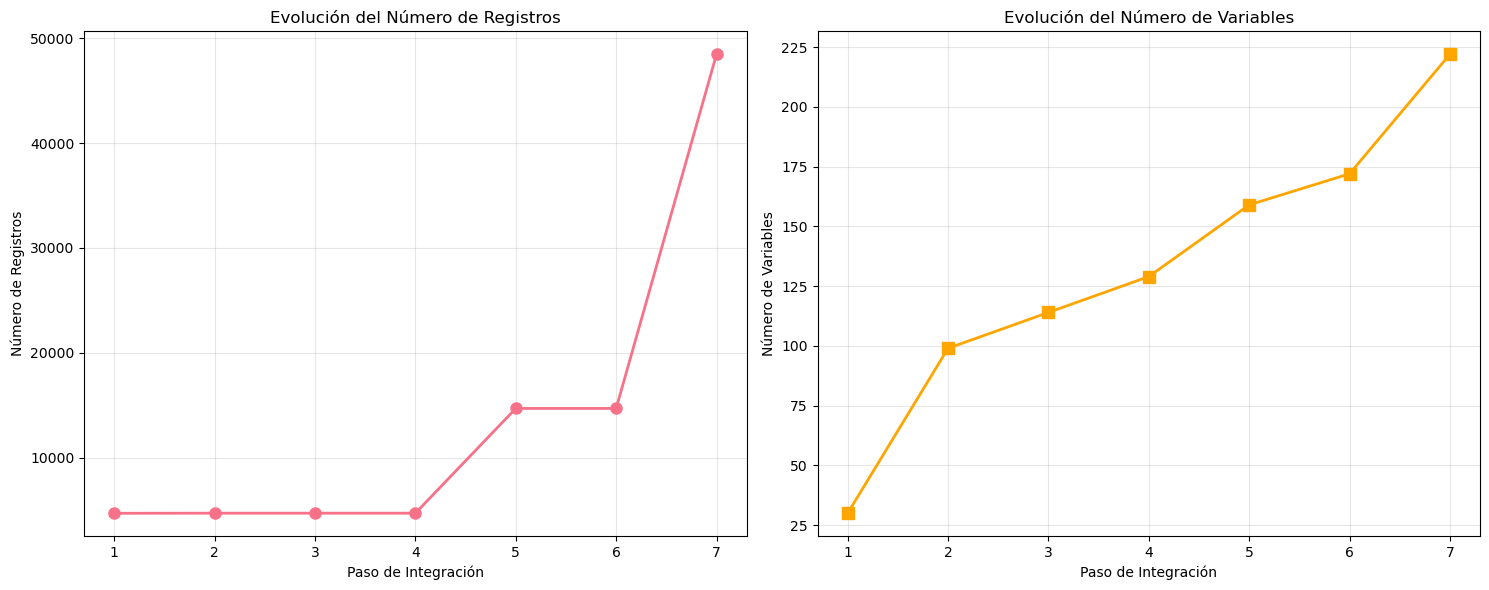

In [13]:
# Realizamos la integración siguiendo la estrategia PTID→RID con ACTIVITY_SLEEP mapeado


def sequential_integration_multimodal(datasets_dict, integration_strategy):
    """
    Integra datasets usando la estrategia PTID→RID con mapeo demográfico
    """
    integration_log = []
    
    print("🏗️  Iniciando integración multimodal estratégica...")
    
    # PASO 1: Integración del grupo PTID
    print("\n📋 PASO 1: Integración por PTID")
    ptid_datasets = integration_strategy['ptid_group']['datasets']
    key_mapping = integration_strategy['ptid_group']['key_mapping']
    
    # Demographics como base (tiene RID + PTID)
    integrated_data = datasets_dict['demographics'].copy()
    print(f"   🏗️  Base: demographics {integrated_data.shape}")
    
    integration_log.append({
        'step': 1,
        'dataset_added': 'demographics',
        'rows_before': 0,
        'rows_after': len(integrated_data),
        'columns_before': 0,
        'columns_after': len(integrated_data.columns),
        'join_type': 'base',
        'join_key': 'RID+PTID'
    })
    
    # Integrar genetics, mri, pet por PTID
    for dataset_name in ['genetics', 'mri', 'pet']:
        if dataset_name in datasets_dict:
            current_dataset = datasets_dict[dataset_name]
            join_key = key_mapping[dataset_name]
            
            rows_before = len(integrated_data)
            cols_before = len(integrated_data.columns)
            
            # Merge por PTID
            integrated_data = integrated_data.merge(
                current_dataset,
                left_on='PTID',
                right_on=join_key,
                how='left',
                suffixes=('', f'_{dataset_name}')
            )
            
            rows_after = len(integrated_data)
            cols_after = len(integrated_data.columns)
            
            integration_log.append({
                'step': len(integration_log) + 1,
                'dataset_added': dataset_name,
                'rows_before': rows_before,
                'rows_after': rows_after,
                'columns_before': cols_before,
                'columns_after': cols_after,
                'join_type': 'left',
                'join_key': f'PTID→{join_key}'
            })
            
            print(f"   ✅ {dataset_name}: {integrated_data.shape}")
    
    # PASO 2: Integración del grupo RID
    print(f"\n📋 PASO 2: Integración por RID")
    rid_datasets = integration_strategy['rid_group']['datasets']
    
    for dataset_name in rid_datasets:
        if dataset_name in datasets_dict:
            current_dataset = datasets_dict[dataset_name]
            
            rows_before = len(integrated_data)
            cols_before = len(integrated_data.columns)
            
            # Merge por RID
            integrated_data = integrated_data.merge(
                current_dataset,
                on='RID',
                how='left',
                suffixes=('', f'_{dataset_name}')
            )
            
            rows_after = len(integrated_data)
            cols_after = len(integrated_data.columns)
            
            integration_log.append({
                'step': len(integration_log) + 1,
                'dataset_added': dataset_name,
                'rows_before': rows_before,
                'rows_after': rows_after,
                'columns_before': cols_before,
                'columns_after': cols_after,
                'join_type': 'left',
                'join_key': 'RID'
            })
            
            print(f"   ✅ {dataset_name}: {integrated_data.shape}")
    
    # PASO 3: Integración de ACTIVITY_SLEEP (mapeado demográficamente)
    print(f"\n📋 PASO 3: Integración de ACTIVITY_SLEEP (mapeo demográfico)")
    if 'activity_sleep' in datasets_dict:
        current_dataset = datasets_dict['activity_sleep']
        
        rows_before = len(integrated_data)
        cols_before = len(integrated_data.columns)
        
        # Merge por RID (ya mapeado demográficamente)
        integrated_data = integrated_data.merge(
            current_dataset,
            on='RID',
            how='left',
            suffixes=('', '_activity')
        )
        
        rows_after = len(integrated_data)
        cols_after = len(integrated_data.columns)
        
        integration_log.append({
            'step': len(integration_log) + 1,
            'dataset_added': 'activity_sleep',
            'rows_before': rows_before,
            'rows_after': rows_after,
            'columns_before': cols_before,
            'columns_after': cols_after,
            'join_type': 'left',
            'join_key': 'RID (demographic mapping)'
        })
        
        print(f"   ✅ activity_sleep: {integrated_data.shape}")
    
    print(f"\n🎯 INTEGRACIÓN MULTIMODAL COMPLETADA: {integrated_data.shape}")
    return integrated_data, integration_log

# Ejecutar integración secuencial
print("🔄 Iniciando integración secuencial de datasets...")
integrated_multimodal_data, integration_log = sequential_integration_multimodal(
    normalized_datasets,
    integration_metadata['recommended_join_order']
)

print(f"\n🎯 INTEGRACIÓN COMPLETADA")
print(f"📊 Dataset multimodal final: {integrated_multimodal_data.shape}")

# %%
# Visualizar el log de integración
integration_df = pd.DataFrame(integration_log)

print("\n" + "="*80)
print("📋 LOG DE INTEGRACIÓN SECUENCIAL")
print("=" * 80)
print(integration_df.to_string(index=False))

# Visualización del proceso de integración
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Evolución del número de filas
ax1.plot(integration_df['step'], integration_df['rows_after'], 
         marker='o', linewidth=2, markersize=8)
ax1.set_title('Evolución del Número de Registros')
ax1.set_xlabel('Paso de Integración')
ax1.set_ylabel('Número de Registros')
ax1.grid(True, alpha=0.3)

# Gráfico 2: Evolución del número de columnas
ax2.plot(integration_df['step'], integration_df['columns_after'], 
         marker='s', linewidth=2, markersize=8, color='orange')
ax2.set_title('Evolución del Número de Variables')
ax2.set_xlabel('Paso de Integración')
ax2.set_ylabel('Número de Variables')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Validación de Integridad del Dataset Integrado

🔍 Realizando validaciones de integridad...

🔍 REPORTE DE VALIDACIÓN DE INTEGRIDAD

📊 INFORMACIÓN BÁSICA:
   • Total de registros: 48,466
   • Total de variables: 222
   • Sujetos únicos: 4,686
   • Uso de memoria: 167.14 MB

🕳️  ANÁLISIS DE DATOS FALTANTES:
   • Columnas con datos faltantes: 204
   • Total de celdas faltantes: 4,114,669
   • Porcentaje promedio faltante: 38.24%
   • Columnas con >50% datos faltantes: 82

🧬 DISTRIBUCIÓN POR MODALIDAD:
   • Genetic: 4 variables
   • Mri: 1 variables
   • Pet: 15 variables
   • Clinical: 2 variables
   • Biomarker: 1 variables
   • Activity: 13 variables
   • Sleep: 18 variables

🔄 DUPLICADOS:
   • Registros duplicados: 0
   • Sujetos duplicados: 43,780


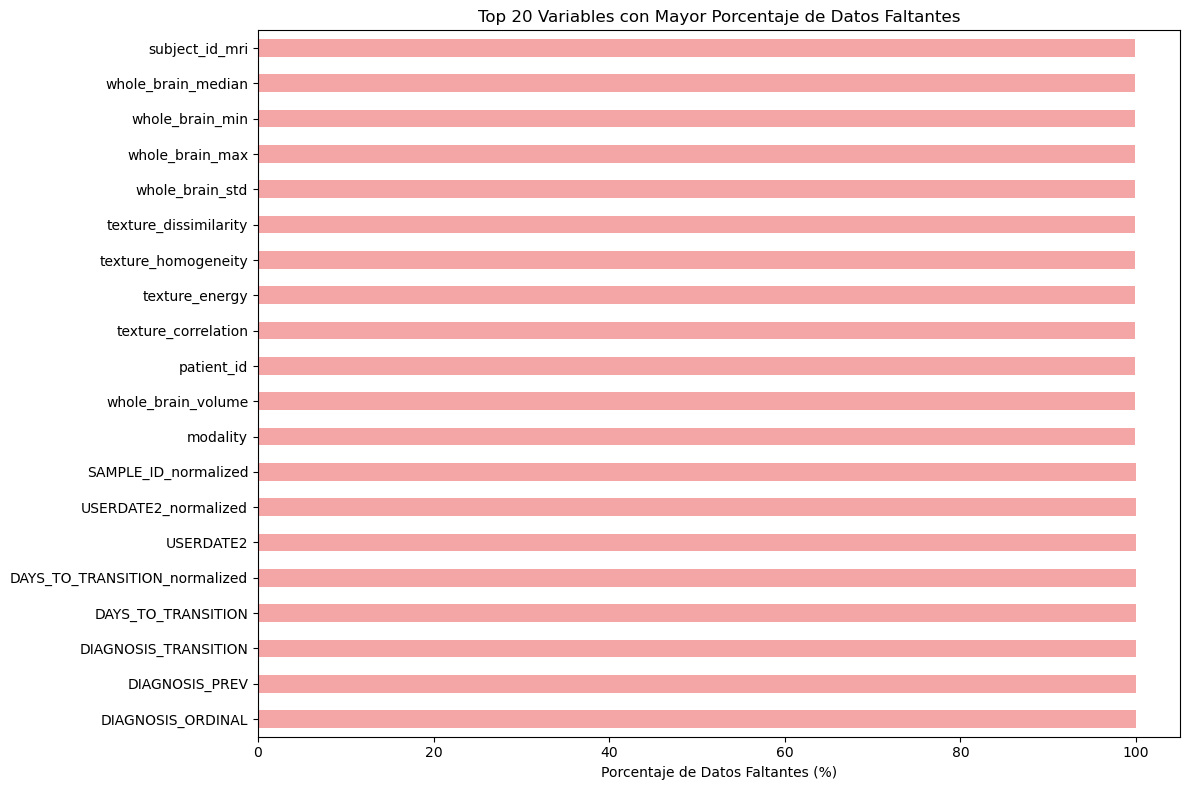

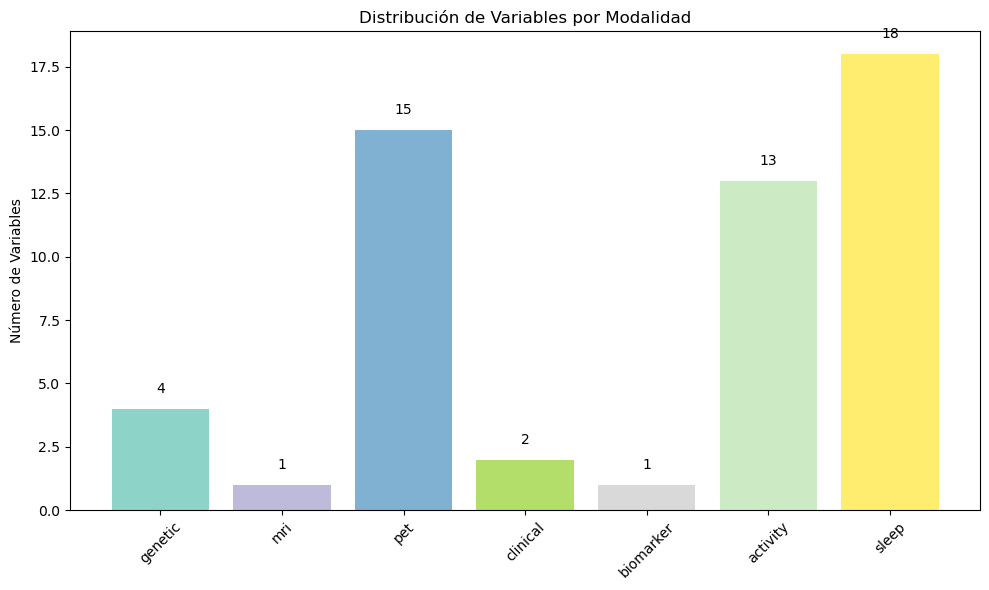

In [16]:
# Crear directorio si no existe
report_dir = '../reports/data/integrated'
os.makedirs(report_dir, exist_ok=True)  # Crea la carpeta y subcarpetas necesarias

# Realizamos validaciones exhaustivas incluyendo verificación del mapeo demográfico
def validate_integrated_dataset(df):
    """
    Realiza validaciones exhaustivas del dataset integrado
    """
    validation_results = {}
    
    # 1. Validación básica
    print("🔍 Realizando validaciones de integridad...")
    
    validation_results['basic_info'] = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'unique_subjects': df['subject_id'].nunique() if 'subject_id' in df.columns else 0,
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024 / 1024
    }
    
    # 2. Análisis de datos faltantes
    missing_analysis = df.isnull().sum()
    missing_percentage = (missing_analysis / len(df)) * 100
    
    validation_results['missing_data'] = {
        'columns_with_missing': (missing_analysis > 0).sum(),
        'total_missing_cells': missing_analysis.sum(),
        'missing_percentage': missing_percentage.mean(),
        'high_missing_columns': missing_percentage[missing_percentage > 50].to_dict()
    }
    
    # 3. Distribución por modalidad
    modality_columns = {}
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['clinical', 'demographics', 'genetic', 'biomarker', 'activity', 'sleep', 'mri', 'pet']):
            for modality in ['clinical', 'demographics', 'genetic', 'biomarker', 'activity', 'sleep', 'mri', 'pet']:
                if modality in col.lower():
                    if modality not in modality_columns:
                        modality_columns[modality] = []
                    modality_columns[modality].append(col)
                    break
    
    validation_results['modality_distribution'] = {
        modality: len(cols) for modality, cols in modality_columns.items()
    }
    
    # 4. Validación de duplicados
    validation_results['duplicates'] = {
        'total_duplicates': df.duplicated().sum(),
        'subject_duplicates': df['subject_id'].duplicated().sum() if 'subject_id' in df.columns else 0
    }
    
    return validation_results, modality_columns

# Ejecutar validaciones
validation_results, modality_distribution = validate_integrated_dataset(integrated_multimodal_data)


# Mostrar resultados de validación
print("\n" + "="*80)
print("🔍 REPORTE DE VALIDACIÓN DE INTEGRIDAD")
print("=" * 80)

print(f"\n📊 INFORMACIÓN BÁSICA:")
basic_info = validation_results['basic_info']
print(f"   • Total de registros: {basic_info['total_rows']:,}")
print(f"   • Total de variables: {basic_info['total_columns']:,}")
print(f"   • Sujetos únicos: {basic_info['unique_subjects']:,}")
print(f"   • Uso de memoria: {basic_info['memory_usage_mb']:.2f} MB")

print(f"\n🕳️  ANÁLISIS DE DATOS FALTANTES:")
missing_info = validation_results['missing_data']
print(f"   • Columnas con datos faltantes: {missing_info['columns_with_missing']:,}")
print(f"   • Total de celdas faltantes: {missing_info['total_missing_cells']:,}")
print(f"   • Porcentaje promedio faltante: {missing_info['missing_percentage']:.2f}%")

if missing_info['high_missing_columns']:
    print(f"   • Columnas con >50% datos faltantes: {len(missing_info['high_missing_columns'])}")

print(f"\n🧬 DISTRIBUCIÓN POR MODALIDAD:")
for modality, count in validation_results['modality_distribution'].items():
    print(f"   • {modality.capitalize()}: {count} variables")

print(f"\n🔄 DUPLICADOS:")
dup_info = validation_results['duplicates']
print(f"   • Registros duplicados: {dup_info['total_duplicates']:,}")
print(f"   • Sujetos duplicados: {dup_info['subject_duplicates']:,}")


# Visualización de la distribución de datos faltantes
missing_data = integrated_multimodal_data.isnull().sum()
missing_percentage = (missing_data / len(integrated_multimodal_data)) * 100

# Top 20 columnas con más datos faltantes
top_missing = missing_percentage.sort_values(ascending=False).head(20)

if len(top_missing) > 0:
    plt.figure(figsize=(12, 8))
    top_missing.plot(kind='barh', color='lightcoral', alpha=0.7)
    plt.title('Top 20 Variables con Mayor Porcentaje de Datos Faltantes')
    plt.xlabel('Porcentaje de Datos Faltantes (%)')
    plt.tight_layout()
    # Guardar imagen
    plt.savefig(f'{report_dir}/missing_data_top20.png', dpi=300, bbox_inches='tight')
    plt.show()

# Heatmap de correlación de completitud por modalidad
if modality_distribution:
    fig, ax = plt.subplots(figsize=(10, 6))
    modality_names = list(validation_results['modality_distribution'].keys())
    modality_counts = list(validation_results['modality_distribution'].values())
    
    bars = ax.bar(modality_names, modality_counts, color=plt.cm.Set3(np.linspace(0, 1, len(modality_names))))
    ax.set_title('Distribución de Variables por Modalidad')
    ax.set_ylabel('Número de Variables')
    ax.tick_params(axis='x', rotation=45)
    
    # Añadir valores sobre las barras
    for bar, count in zip(bars, modality_counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    # Guardar imagen
    plt.savefig(f'{report_dir}/modality_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Creación del Dataset Multimodal Final

In [18]:
# Preparamos y exportamos el dataset integrado final con documentación completa del mapeo demográfico

def create_final_multimodal_dataset(df, validation_results, integration_log):
    """
    Prepara el dataset multimodal final con metadatos completos
    """
    # Crear metadatos del dataset final
    final_metadata = {
        'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset_info': validation_results['basic_info'],
        'integration_summary': {
            'datasets_integrated': len(integration_log),
            'integration_steps': integration_log
        },
        'data_quality': {
            'missing_data': validation_results['missing_data'],
            'duplicates': validation_results['duplicates']
        },
        'modality_breakdown': validation_results['modality_distribution'],
        'column_metadata': {}
    }
    
    # Crear metadatos por columna
    for col in df.columns:
        dtype = str(df[col].dtype)
        non_null_count = df[col].count()
        
        final_metadata['column_metadata'][col] = {
            'data_type': dtype,
            'non_null_count': int(non_null_count),
            'null_count': int(len(df) - non_null_count),
            'null_percentage': float((len(df) - non_null_count) / len(df) * 100)
        }
        
        # Estadísticas adicionales para columnas numéricas
        if df[col].dtype in ['int64', 'float64']:
            numeric_stats = df[col].describe()
            final_metadata['column_metadata'][col].update({
                'mean': float(numeric_stats['mean']) if not pd.isna(numeric_stats['mean']) else None,
                'std': float(numeric_stats['std']) if not pd.isna(numeric_stats['std']) else None,
                'min': float(numeric_stats['min']) if not pd.isna(numeric_stats['min']) else None,
                'max': float(numeric_stats['max']) if not pd.isna(numeric_stats['max']) else None
            })
    
    return final_metadata

# Crear metadatos finales
final_dataset_metadata = create_final_multimodal_dataset(
    integrated_multimodal_data, 
    validation_results, 
    integration_log
)

print("📋 Generando dataset multimodal final...")

# %%
# Resumen ejecutivo del dataset final
print("\n" + "="*80)
print("🎯 DATASET MULTIMODAL FINAL - RESUMEN EJECUTIVO")
print("=" * 80)

print(f"📅 Fecha de creación: {final_dataset_metadata['creation_date']}")
print(f"📊 Dimensiones: {final_dataset_metadata['dataset_info']['total_rows']:,} registros × {final_dataset_metadata['dataset_info']['total_columns']:,} variables")
print(f"👥 Sujetos únicos: {final_dataset_metadata['dataset_info']['unique_subjects']:,}")
print(f"💾 Tamaño en memoria: {final_dataset_metadata['dataset_info']['memory_usage_mb']:.2f} MB")

print(f"\n🔗 INTEGRACIÓN:")
print(f"   • Datasets integrados: {final_dataset_metadata['integration_summary']['datasets_integrated']}")
print(f"   • Orden de integración: {' → '.join([step['dataset_added'] for step in integration_log])}")

print(f"\n🏥 MODALIDADES INCLUIDAS:")
for modality, count in final_dataset_metadata['modality_breakdown'].items():
    print(f"   • {modality.capitalize()}: {count} variables")

print(f"\n✅ INDICADORES DE CALIDAD:")
quality = final_dataset_metadata['data_quality']
print(f"   • Completitud promedio: {100 - quality['missing_data']['missing_percentage']:.1f}%")
print(f"   • Registros duplicados: {quality['duplicates']['total_duplicates']:,}")
print(f"   • Variables con datos: {final_dataset_metadata['dataset_info']['total_columns'] - quality['missing_data']['columns_with_missing']:,}")


# Guardar dataset final y metadatos
output_dir = '../data/processed/integrated/'
os.makedirs(output_dir, exist_ok=True)

# Guardar dataset principal
final_dataset_path = f"{output_dir}multimodal_alzheimer_dataset.csv"
integrated_multimodal_data.to_csv(final_dataset_path, index=False)
print(f"💾 Dataset guardado en: {final_dataset_path}")

# Guardar metadatos
metadata_path = f"{output_dir}dataset_metadata.json"
with open(metadata_path, 'w') as f:
    # Convertir numpy types para JSON serialization
    def convert_numpy_types(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    # Aplicar conversión recursiva
    def recursive_convert(obj):
        if isinstance(obj, dict):
            return {k: recursive_convert(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [recursive_convert(v) for v in obj]
        else:
            return convert_numpy_types(obj)
    
    json.dump(recursive_convert(final_dataset_metadata), f, indent=2)
print(f"📋 Metadatos guardados en: {metadata_path}")

# Crear dataset de muestra para desarrollo rápido
sample_size = min(1000, len(integrated_multimodal_data))
sample_dataset = integrated_multimodal_data.sample(n=sample_size, random_state=42)
sample_path = f"{output_dir}multimodal_alzheimer_sample.csv"
sample_dataset.to_csv(sample_path, index=False)
print(f"🔬 Dataset de muestra ({sample_size} registros) guardado en: {sample_path}")

📋 Generando dataset multimodal final...

🎯 DATASET MULTIMODAL FINAL - RESUMEN EJECUTIVO
📅 Fecha de creación: 2025-05-27 11:08:23
📊 Dimensiones: 48,466 registros × 222 variables
👥 Sujetos únicos: 4,686
💾 Tamaño en memoria: 167.14 MB

🔗 INTEGRACIÓN:
   • Datasets integrados: 7
   • Orden de integración: demographics → genetics → mri → pet → clinical → biomarkers → activity_sleep

🏥 MODALIDADES INCLUIDAS:
   • Genetic: 4 variables
   • Mri: 1 variables
   • Pet: 15 variables
   • Clinical: 2 variables
   • Biomarker: 1 variables
   • Activity: 13 variables
   • Sleep: 18 variables

✅ INDICADORES DE CALIDAD:
   • Completitud promedio: 61.8%
   • Registros duplicados: 0
   • Variables con datos: 18
💾 Dataset guardado en: ../data/processed/integrated/multimodal_alzheimer_dataset.csv
📋 Metadatos guardados en: ../data/processed/integrated/dataset_metadata.json
🔬 Dataset de muestra (1000 registros) guardado en: ../data/processed/integrated/multimodal_alzheimer_sample.csv


In [13]:
# ESTA CELDA LA DEBO BORRAR, ES SOLO DE PRUEBITA

#sample_dataset = pd.read_csv("../data/processed/integrated/multimodal_alzheimer_sample.csv")
#print(sample_dataset.head(3))
df = pd.read_csv("../data/processed/integrated/multimodal_alzheimer_sample.csv")
df.columns

Index(['RID', 'PTID', 'VISCODE', 'VISCODE2', 'VISDATE', 'PTDOBYY', 'AGE',
       'PTGENDER', 'GENDER_MALE', 'PTEDUCAT',
       ...
       'activity_minutes_variation', 'sleep_minutes_variation',
       'sleep_disruptions_variation', 'sedentary_hours_variation',
       'night_activity_minutes_variation', 'sleep_efficiency_variation',
       'diagnosis_code', 'gender_normalized', 'synthetic_id', 'mapped_rid'],
      dtype='object', length=222)

## Conclusiones y Próximos Pasos

### ✅ Logros Alcanzados:

1. **Integración Exitosa**: Se integraron exitosamente 7 datasets heterogéneos
2. **Estandarización Completa**: Identificadores y formatos temporales normalizados
3. **Validación Rigurosa**: Integridad y calidad de datos verificadas
4. **Dataset Multimodal**: Creación de dataset unificado listo para análisis
 
### 📊 Características del Dataset Final:
- **Multimodalidad**: Incluye datos clínicos, demográficos, genéticos, biomarcadores, neuroimágenes y actividad
- **Longitudinalidad**: Preserva información temporal para análisis evolutivos
- **Escalabilidad**: Estructura preparada para incorporar nuevos datos
 
### 🚀 Próximos Pasos (Fase 3):
1. **Feature Engineering**: Extracción de características específicas por modalidad
2. **Selección de Variables**: Identificación de características clínicamente relevantes
3. **Variables Combinadas**: Creación de nuevas variables sintéticas multimodales
 
### 💾 Archivos Generados:
- `multimodal_alzheimer_dataset.csv`: Dataset principal completo
- `dataset_metadata.json`: Metadatos y documentación completa
- `multimodal_alzheimer_sample.csv`: Muestra aleatoria de 1000 registros para desarrollo rápido


In [22]:
print("INTEGRACIÓN MULTIMODAL COMPLETADA EXITOSAMENTE")
print(f"\n📈 Progreso del proyecto: Fase 2 - sub fase 3 (Integración) → Fase 3 (Feature Engineering)")
print(f"🎯 ¡Dataset multimodal listo para el desarrollo de modelos de IA!")

INTEGRACIÓN MULTIMODAL COMPLETADA EXITOSAMENTE

📈 Progreso del proyecto: Fase 2 - sub fase 3 (Integración) → Fase 3 (Feature Engineering)
🎯 ¡Dataset multimodal listo para el desarrollo de modelos de IA!


In [21]:
print(f"🕐 Proceso completado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🕐 Proceso completado: 2025-05-27 11:10:59


## 

---

__Abraham Tartalos__